In [1]:
!git clone https://github.com/openai/CLIP.git
%cd CLIP/
%pip install ftfy
import clip
%cd ../

fatal: destination path 'CLIP' already exists and is not an empty directory.


/home/ubuntu/isa_CSC413_project/CLIP
Looking in indexes: https://pypi.internal-mirrors.ucloud.cn/simple
Note: you may need to restart the kernel to use updated packages.
/home/ubuntu/isa_CSC413_project


In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load clip
perceptor, preprocess = clip.load('ViT-B/32')
perceptor = perceptor.to(device)

In [4]:
# from lab03
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [5]:
%pip install huggingface_hub

Looking in indexes: https://pypi.internal-mirrors.ucloud.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
from huggingface_hub import hf_hub_download

weights_path = hf_hub_download(
    repo_id="lfw3/Genshin_Stats_MLP_to_CLIP",
    filename="best_model_weights.pt"
)

# mlp.py contains the model architecture (class definition)
code_path = hf_hub_download(
    repo_id="lfw3/Genshin_Stats_MLP_to_CLIP",
    filename="clip_mlp.py"
)

/home/ubuntu/anaconda3/envs/isaenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import importlib.util
spec = importlib.util.spec_from_file_location("mlp", code_path)
mlp_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mlp_module)

MLP = mlp_module.CLIPOffsetMLP

In [8]:
model = MLP()
checkpoint = torch.load(weights_path, map_location="cpu")
state = torch.load(weights_path, map_location="cpu")
# state = checkpoint["model_state_dict"]
model.load_state_dict(state)
model.to("cuda")
model.eval()

CLIPOffsetMLP(
  (mlp): Sequential(
    (0): Linear(in_features=1559, out_features=1024, bias=True)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [9]:
# encode the text into the CLIP latent space using this code
base_text = "Genshin-style character"
base_tx = clip.tokenize(base_text).to(device)
E_text = perceptor.encode_text(base_tx)

In [10]:
# batch_size = 1
# # region: 6 unique values - ['Mondstadt' 'Sumeru' 'Inazuma' 'Liyue' 'Fontaine' 'Snezhnaya']
# # vision: 7 unique values - ['Geo' 'Dendro' 'Pyro' 'Hydro' 'Electro' 'Cryo' 'Anemo']
# # weapon_type: 5 unique values - ['Sword' 'Bow' 'Claymore' 'Catalyst' 'Polearm']
# # body_figure: 5 unique values - ['Medium Male' 'Tall Male' 'Medium Female' 'Tall Female' 'Short Female']
# region = 2
# vision = 3
# weapon_type = 0
# body_figure = 1

# # encode the text into the CLIP latent space using this code
# name_text = "bushi gemer"
# name_tx = clip.tokenize(name_text).to(device)
# E_name = perceptor.encode_text(name_tx)

# # encode the text into the CLIP latent space using this code
# constellation_text = "computer"
# constellation_tx = clip.tokenize(constellation_text).to(device)
# E_constellation = perceptor.encode_text(constellation_tx)

# # encode the text into the CLIP latent space using this code
# affiliation_text = "University of Toronto"
# affiliation_tx = clip.tokenize(affiliation_text).to(device)
# E_affiliation = perceptor.encode_text(affiliation_tx)

# string_embeds = torch.stack([E_name, E_constellation, E_affiliation]).unsqueeze(0).to(device)
# categorical_inputs = torch.tensor([region, vision, weapon_type, body_figure]).unsqueeze(0).to(device)
# base_text_embed = E_text.repeat(batch_size, 1).to(device)

# with torch.no_grad():
#     mlp_output = model(string_embeds, categorical_inputs, base_text_embed)

# Load the diffuser model


In [11]:
%%capture
%pip install -U peft transformers diffusers

In [12]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
).to("cuda")

pipeline.load_lora_weights(
    "mary-ruiliii/genshin-style_character_generator",
    adapter_name="genshin_lora"
)

# fuse into the model (this writes into the UNet + text encoders on GPU)
pipeline.fuse_lora(adapter_names=["genshin_lora"], lora_scale=1.0)

pipeline.unload_lora_weights()

# now save the fused model
pipeline.save_pretrained("./genshin_sdxl_lora_fused")

Loading pipeline components...: 100%|██████████| 7/7 [00:46<00:00,  6.71s/it]
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


In [13]:
pipe = DiffusionPipeline.from_pretrained(
    "./genshin_sdxl_lora_fused",
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 19.41it/s]


In [14]:
# Check UNet
for name, module in pipe.unet.named_modules():
    if "lora" in name.lower():
        print("Found LoRA:", name)

# Check text encoders
for name, module in pipe.text_encoder.named_modules():
    if "lora" in name.lower():
        print("Found LoRA:", name)


In [ ]:
# from huggingface_hub import create_repo
# repo_id = "mary-ruiliii/genshin-sdxl-lora-fused"

# create_repo(repo_id, exist_ok=True)

RepoUrl('https://huggingface.co/mary-ruiliii/genshin-sdxl-lora-fused', endpoint='https://huggingface.co', repo_type='model', repo_id='mary-ruiliii/genshin-sdxl-lora-fused')

In [ ]:
from huggingface_hub import upload_folder

upload_folder(
    repo_id="mary-ruiliii/genshin-sdxl-lora-fused",
    folder_path="./genshin_sdxl_lora_fused",
    commit_message="Upload fused SDXL + LoRA model"
)

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            











Processing Files (0 / 3)                :   2%|▏         |  117MB / 6.96GB,  587MB/s  





Processing Files (0 / 3)                :   3%|▎         |  226MB / 6.96GB,  566MB/s  





Processing Files (1 / 3)                :   4%|▍         |  301MB / 6.96GB,  503MB/s  





Processing Files (1 / 3)                :   5%|▌         |  352MB / 6.96GB,  440MB/s  













Processing Files (1 / 4)                :   6%|▌         |  416MB / 6.96GB,  416MB/s  









Processing Files (1 / 4)                :   8%|▊         |  539MB / 6.96GB,  449MB/s  









Processing Files (1 / 4)                :   9%|▉         |  646MB / 6.96GB,  461MB/s  









Processing Files (1 / 4)                :  11%|█         |  770MB / 6.96GB,  481MB/s  









Processing Files (1 / 4)                :  13%|█▎        |  886MB / 6.96GB,  492MB/s  









Processing Files (1 / 4)                :  14%|█▍ 

CommitInfo(commit_url='https://huggingface.co/mary-ruiliii/genshin-sdxl-lora-fused/commit/ad83f01b8dcbc7084a4c3f597fbd5ae9f1a716c8', commit_message='Upload fused SDXL + LoRA model', commit_description='', oid='ad83f01b8dcbc7084a4c3f597fbd5ae9f1a716c8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mary-ruiliii/genshin-sdxl-lora-fused', endpoint='https://huggingface.co', repo_type='model', repo_id='mary-ruiliii/genshin-sdxl-lora-fused'), pr_revision=None, pr_num=None)

In [ ]:
proj_prompt = torch.nn.Linear(512, 2048).to(device).half()
proj_pooled = torch.nn.Linear(768, 1280).to(device).half()

# Our own embeddings
base_text = "Genshin-style character"

text_inputs = pipe.tokenizer(
    base_text,
    padding="max_length",
    max_length=pipe.tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
).to(device)

my_pooled_embeds = pipe.text_encoder(text_inputs.input_ids)[1].half().cuda()    # [1, 768]
my_pooled_embeds = proj_pooled(my_pooled_embeds)                  # [1, 1280]

my_prompt_embeds = mlp_output.half().cuda()             # [1, 512]
my_prompt_embeds = proj_prompt(my_prompt_embeds)        # [1, 1280]

seq_len = 77
my_prompt_embeds = my_prompt_embeds.unsqueeze(1).repeat(1, seq_len, 1)

print("my_prompt_embeds shape:", my_prompt_embeds.shape)
print("my_pooled_embeds shape:", my_pooled_embeds.shape)

my_prompt_embeds shape: torch.Size([1, 77, 2048])
my_pooled_embeds shape: torch.Size([1, 1280])


In [ ]:
# Invoke pipeline to generate image
# prompt_embeds_test = torch.zeros_like(my_pooled_embeds)
# image = pipe(
#     prompt_embeds=my_prompt_embeds,
#     pooled_prompt_embeds=my_pooled_embeds,
#     num_inference_steps=50,
#     guidance_scale=7.0,
#     height=1024,
#     width=1024
# ).images[0]
prompt = "Genshin-style character, tall male, pyro vision, from Mondstadt"

# Invoke pipeline to generate image
image = pipe(
    prompt = prompt,
    num_inference_steps=50,
    height=400,
    width=400,
    guidance_scale=7.0,
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 12.92it/s]
/home/ubuntu/anaconda3/envs/isaenv/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion_xl/pipeline_stable_diffusion_xl.py:748: FutureWarning: `upcast_vae` is deprecated and will be removed in version 1.0.0. `upcast_vae` is deprecated. Please use `pipe.vae.to(torch.float32)`. For more details, please refer to: https://github.com/huggingface/diffusers/pull/12619#issue-3606633695.
  deprecate(


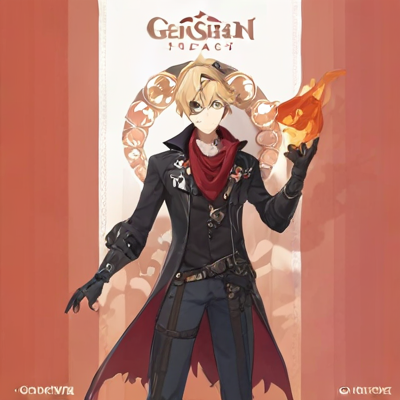

In [16]:
image

In [ ]:
# Save Image
image.save(f"new_character.png")

# Something else

In [ ]:
def precision(model, dataset):
    """
    Compute the precision of `model` over the `dataset`.  We will take the
    **most probable class** as the class predicted by the model.

    Parameters:
        `model` - A PyTorch MLPModel
        `dataset` - A data structure that acts like a list of 2-tuples of
                  the form (x, t), where `x` is a PyTorch tensor of shape
                  [1, 28, 28] representing an MedMNIST image,
                  and `t` is the corresponding binary target label

    Returns: a floating-point value between 0 and 1.
    """
    true_pos, total_pred_pos = 0, 0
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for img, t in loader:
        X = img.reshape(-1, 784)
        z = model(X)

        y = torch.sigmoid(z) > 0.5 # TODO: pred should be a [N, 1] tensor with binary
                    # predictions, (0 or 1 in each entry)

        yt = y + t
        true_pos += int(torch.sum(yt == 2))
        total_pred_pos += int(torch.sum(y == 1))

        # TODO: update total_pred_pos and true_pos
    return true_pos / total_pred_pos


def recall(model, dataset):
    """
    Compute the recall (or sensitivity) of `model` over the `dataset`.  We will
    take the **most probable class** as the class predicted by the model.

    Parameters:
        `model` - A PyTorch MLPModel
        `dataset` - A data structure that acts like a list of 2-tuples of
                  the form (x, t), where `x` is a PyTorch tensor of shape
                  [1, 28, 28] representing an MedMNIST image,
                  and `t` is the corresponding binary target label

    Returns: a floating-point value between 0 and 1.
    """
    true_pos, total_actual_pos = 0, 0 # track the true and false positive
    loader = torch.utils.data.DataLoader(dataset, batch_size=100)
    for img, t in loader:
        X = img.reshape(-1, 784)
        z = model(X)

        y = torch.sigmoid(z) > 0.5 # TODO: pred should be a [N, 1] tensor with binary
                    # predictions, (0 or 1 in each entry)

        yt = y + t
        true_pos += int(torch.sum(yt == 2))
        total_actual_pos += int(torch.sum(t == 1))

        # TODO: update total_pos and true_pos
    return true_pos / total_actual_pos

print("Precision(Training)", precision(model, train_data))
print("Recall(Training)", recall(model, train_data))
print("Precision(Validation)", precision(model, val_data))
print("Recall(Validation)", recall(model, val_data))

In [ ]:
m_once = MLPModel()
train_model(m_once, train_data, val_data, learning_rate=0.5, batch_size=500, num_epochs=1)
print("Training Accuracy:", accuracy(m_once, train_data))
print("Validation Accuracy:", accuracy(m_once, val_data))
z = model(X.view(-1, 784))
y = torch.sigmoid(z)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_prediction(model, data, sample=1000):
    loader = torch.utils.data.DataLoader(data, batch_size=sample, shuffle=True)
    for X, t in loader:
        z = model(X.view(-1, 784))
        y = torch.sigmoid(z)
        break
    y = y.detach().numpy()
    t = t.detach().numpy()
    return y, t

y, t = get_prediction(model, val_data)
y = y > 0.5
cm = confusion_matrix(t, y)
cmp = ConfusionMatrixDisplay(cm, display_labels=["0", "1"])
cmp.plot()
plt.title("Confusion Matrix (Val Data)")

In [ ]:
m_once = MLPModel()
train_model(m_once, train_data, val_data, learning_rate=0.5, batch_size=500, num_epochs=1)
print("Training Accuracy:", accuracy(m_once, train_data))
print("Validation Accuracy:", accuracy(m_once, val_data))

y, t = get_prediction(m_once, val_data)
y = y > 0.5
ConfusionMatrixDisplay(confusion_matrix(t, y), display_labels=["0", "1"]).plot()
plt.title("Confusion Matrix (Val Data)")